In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os 
import pandas as pd 
import datetime 


## KITTY DATASET 
In this analysis of visual odometry I'm using kitty dataset that you can get at: https://www.cvlibs.net/datasets/kitti/eval_odometry.php. <br>
Kitty dataset contains data from stereo camera, 3D lidar, ground thruth poses from gps and calibration files for camera. For more info read kitty_readme.txt

### Obtain Ground truth poses
Poses are normally represented in a 3x4 transormation matrix T. First 3 colums are 3x3 rotation matrix and last column is 3x1 translation vector. <br>
In kitty dataset sequance of 4541 ground truth poses (first sequance from dataset) is stored as 4541x12 table. 12 columns come from flattening a 3x4 matrix to one row. <br> Transformation matrixies represent position of the left camera (stereo pair) with respest to the global coordinate frame. Global frame is coordinate frame of the first camera pose. 

In [2]:
# get gt poses in flattened version
ground_truth_poses = pd.read_csv('../KITTY_dataset/ground_truth_poses/07.txt', delimiter=' ', header=None)
print("poses shape ", ground_truth_poses.shape)
ground_truth_poses.head(5)


poses shape  (1101, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
0,1.000000,1.197625e-11,1.704638e-10,5.551115e-17,1.197625e-11,1.000000,3.562503e-10,0.000000,1.704638e-10,3.562503e-10,1.000000,2.220446e-16
1,0.999980,5.025123e-04,-6.380358e-03,-4.596714e-03,-5.005160e-04,1.000000,3.144878e-04,-0.002002,6.380515e-03,-3.112871e-04,0.999980,9.154274e-02
2,0.999910,1.061516e-03,-1.340599e-02,-1.001116e-02,-1.058762e-03,0.999999,2.126022e-04,-0.004360,1.340621e-02,-1.983884e-04,0.999910,1.857373e-01
3,0.999780,1.386756e-03,-2.092925e-02,-1.753371e-02,-1.395506e-03,0.999999,-4.034725e-04,-0.006860,2.092867e-02,4.325913e-04,0.999781,2.834672e-01
4,0.999545,2.025309e-03,-3.008212e-02,-2.863192e-02,-2.080074e-03,0.999996,-1.789331e-03,-0.006727,3.007839e-02,1.851091e-03,0.999546,3.873100e-01


In [15]:
# unflatten transformation matrixies 
gt_poses = np.zeros((len(ground_truth_poses),3,4)) # transformation matrixies in 3x4 version
trajectory = []
for npose in range(len(ground_truth_poses)): 
    gt_poses[npose] = (np.array(ground_truth_poses.iloc[npose]).reshape((3,4)))
    #trajectory[npose] = gt_poses[npose].dot(origin)

print(gt_poses.shape)
print(gt_poses[3]) #first pose

(1101, 3, 4)
[[ 9.997800e-01  1.386756e-03 -2.092925e-02 -1.753371e-02]
 [-1.395506e-03  9.999989e-01 -4.034725e-04 -6.859665e-03]
 [ 2.092867e-02  4.325913e-04  9.997809e-01  2.834672e-01]]


In [4]:
# to calculate camera position relative to global frame we need to have camera frame/camera origin  
camera_origin = np.array([0,0,0,1]) # x,y,z,theta

#now we can calculate camera position in n frame  / position not pose !!
second_camera_pose = gt_poses[1].dot(camera_origin)
print(second_camera_pose.round(2))

[-0.   -0.    0.09]


In [12]:
print(gt_poses[:,:,3][:,2])

[2.220446e-16 9.154274e-02 1.857373e-01 ... 9.371050e+00 9.370281e+00
 9.367453e+00]


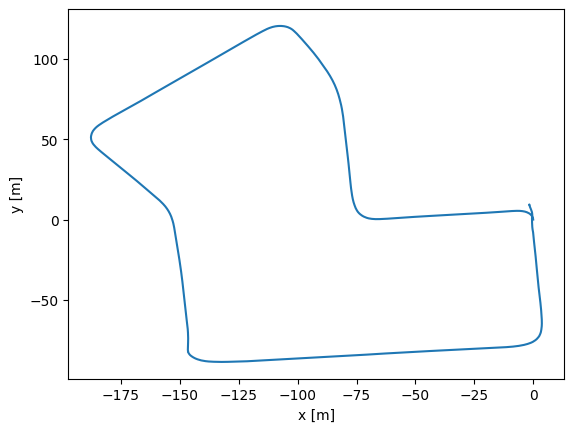

In [5]:
# plot ground truth poses



plt.plot(gt_poses[:,:,3][:,0], gt_poses[:,:,3][:,2])
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.show()

# you have to remember that on plot labels x and y refer to how we normally understand movement
#in kitty dataset frame is set as camera frame, so z is forward/back, x is left/right, and y is up/down (down is positive)
# you can see it on camera pics later

(370, 1226, 3)


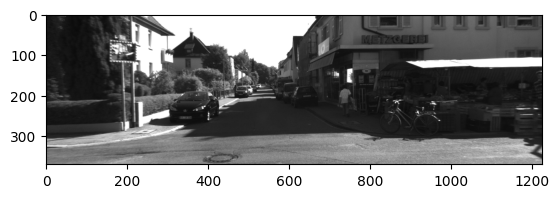

In [6]:
# check out camera images
test_img = cv.imread('../KITTY_dataset/sequences/07/image_0/000000.png') #image_0 is left camera and image_1 is right camera
print(test_img.shape)

%matplotlib inline 
plt.figure()
plt.imshow(test_img)

### Projection Matricies
Projection matrix is matrix that contains extrinsic and intrinsic camera information. Intrinsic matrix have focal lengths in z(forward) and x (right) - f_z,f_z and also where the camera center is (cx,cy). Extrinsic tells you how left and right camera are position in respect to world frame. <br> https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html

In [7]:
# read camera imgs, times and calibration data 
left_camera_imgs = os.listdir('../KITTY_dataset/sequences/07/image_0')
times = pd.read_csv('../KITTY_dataset/sequences/07/times.txt', header=None)

# Calibration data for the cameras: P0/P1 are the 3x4 projection matrices after rectification. Here P0 denotes the left and P1 denotes the
# right camera. Tr transforms a point from velodyne coordinates into the left rectified camera coordinate system. 

calib = pd.read_csv('../KITTY_dataset/sequences/07/calib.txt', delimiter=' ',header=None, index_col=0)
calib.head() # projection matricies 

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
P0:,707.0912,0.0,601.8873,0.00000,0.0,707.0912,183.1104,0.00000,0.0,0.0,1.0,0.000000
P1:,707.0912,0.0,601.8873,-379.81450,0.0,707.0912,183.1104,0.00000,0.0,0.0,1.0,0.000000
P2:,707.0912,0.0,601.8873,46.88783,0.0,707.0912,183.1104,0.11786,0.0,0.0,1.0,0.006203
P3:,707.0912,0.0,601.8873,-333.45970,0.0,707.0912,183.1104,1.93013,0.0,0.0,1.0,0.003318


In [8]:
# reshape calib matrixies to 3x4 
P0 = np.array(calib.loc['P0:']).reshape((3,4))
P1 = np.array(calib.loc['P1:']).reshape((3,4))
P2 = np.array(calib.loc['P2:']).reshape((3,4))
P3 = np.array(calib.loc['P3:']).reshape((3,4))
print("P0 matrix = \n", P0)

P0 matrix = 
 [[707.0912   0.     601.8873   0.    ]
 [  0.     707.0912 183.1104   0.    ]
 [  0.       0.       1.       0.    ]]


In [9]:
# Decomposition of right camera matrix 
intrinsic1,rotation1,translation1,_,_,_,_ = cv.decomposeProjectionMatrix(P1)
print("Right camera intrinsic matrix = \n", intrinsic1)
print("Right camera rotation matrix = \n", rotation1)
print("Right camera translation vector in homogeneous = \n",translation1.round(4))

# translation matrix is in homogeneous coordinates, thats why it has 4 elements
# to get translation matrix in 3d we need to divied it by last element 
translation1 = translation1/ translation1[3]
print("Right camera translation vector = \n",translation1.round(4))

Right camera intrinsic matrix = 
 [[707.0912   0.     601.8873]
 [  0.     707.0912 183.1104]
 [  0.       0.       1.    ]]
Right camera rotation matrix = 
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Right camera translation vector in homogeneous = 
 [[ 0.4732]
 [-0.    ]
 [-0.    ]
 [ 0.881 ]]
Right camera translation vector = 
 [[ 0.5372]
 [-0.    ]
 [-0.    ]
 [ 1.    ]]


In [10]:
# Get transformation matrix RT (Rotation-Translation Matrix)
Rt = np.hstack([rotation1, translation1[:3]])
print("Transformation matrix Rt = \n", Rt.round(4))

Transformation matrix Rt = 
 [[ 1.      0.      0.      0.5372]
 [ 0.      1.      0.     -0.    ]
 [ 0.      0.      1.     -0.    ]]


In kitty dataset right camera projection and translation matricies relates coordinates in respect to left camera frame (normally it would to itself)